In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from global_algorithm_ranking_utils import *
from tqdm import tqdm
from N_plotting_utils import *
from problem_classes import *
from N_ranking_utils import *
from sklearn.metrics.pairwise import *
import sklearn
import scipy

/opt/conda/envs/Base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-13 10:18:15.249038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 10:18:16.539298: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-13 10:18:16.539412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [18]:
def feature_values_boxplot(all_features, features_to_use, features_to_plot=None,ax=None): 
    
    feat=all_features[features_to_use]

    to_plot,_=preprocess_ela(feat.drop(columns=['benchmark']),[])
    to_plot_scaled=pd.DataFrame(MinMaxScaler().fit_transform(to_plot), columns=to_plot.columns, index=to_plot.index)
    if features_to_plot is not None:
        to_plot_scaled=to_plot_scaled[features_to_plot]
    to_plot_scaled['benchmark']=[benchmark_name_mapping(b) for b in feat['benchmark'].values]
    
    
    ax=sns.boxplot(to_plot_scaled.reset_index().melt(['f','benchmark'], var_name='feature name', value_name='scaled feature value'), y='feature name',x='scaled feature value',hue='benchmark',ax=ax,palette=color_palette_4)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #parallel_coordinates(to_plot_scaled.sample(200),class_column='benchmark',color=color_palette_4)

In [3]:
dimension=3
sample_count_dimension_factors=[50,100]
all_features={f'{f}_{sample_count_dimension_factor}d' :get_features(dimension,1000000,feature_dir=f,sample_count_dimension_factor=sample_count_dimension_factor,scaled=True)[1] for f in ['ela_features','transformer_features'] for sample_count_dimension_factor in sample_count_dimension_factors}

functions=[]
for sample_count_dimension_factor in sample_count_dimension_factors:
    all_features[f'merged_features_{sample_count_dimension_factor}d']=all_features[f'transformer_features_{sample_count_dimension_factor}d'].drop(columns=['benchmark']).merge(all_features[f'ela_features_{sample_count_dimension_factor}d'], left_index=True, right_index=True)
    all_features[f'merged_features_{sample_count_dimension_factor}d'].index.name='f'
    all_features[f'transformer_features_{sample_count_dimension_factor}d'].index.name='f'

20337
20308
20273
20269


In [22]:
all_features['ELAsy_50d']=all_features['ela_features_50d'].copy().add_prefix('sy_').rename(columns={'sy_benchmark':'benchmark'})

In [23]:
all_features['ELAsy_50d'].columns

Index(['sy_ela_level.qda_mda_50', 'sy_ela_distr.costs_runtime',
       'sy_ela_level.lda_mda_50', 'sy_ic.costs_runtime',
       'sy_ela_meta.quad_w_interact.adj_r2', 'sy_ela_level.lda_qda_25',
       'sy_ela_level.mmce_qda_50', 'sy_disp.diff_mean_10',
       'sy_ela_meta.lin_simple.intercept', 'sy_disp.ratio_median_25',
       'sy_ic.m0', 'sy_ela_meta.lin_simple.adj_r2', 'sy_nbc.nn_nb.cor',
       'sy_disp.diff_median_02', 'sy_disp.costs_runtime', 'sy_ic.h.max',
       'sy_ela_level.mmce_lda_50', 'sy_ela_meta.lin_simple.coef.min',
       'sy_ic.eps.s', 'sy_nbc.nn_nb.sd_ratio', 'sy_disp.ratio_mean_02',
       'sy_disp.ratio_mean_10', 'sy_nbc.costs_runtime', 'sy_disp.diff_mean_25',
       'sy_pca.expl_var_PC1.cov_init', 'sy_disp.ratio_mean_25',
       'sy_ela_level.mmce_mda_25', 'sy_ela_meta.costs_runtime',
       'sy_disp.ratio_median_02', 'sy_ela_level.mmce_lda_25',
       'sy_ela_distr.skewness', 'sy_disp.ratio_median_05', 'sy_ic.eps.max',
       'sy_disp.diff_median_10', 'sy_basic.co

bbob
affine
random
m4


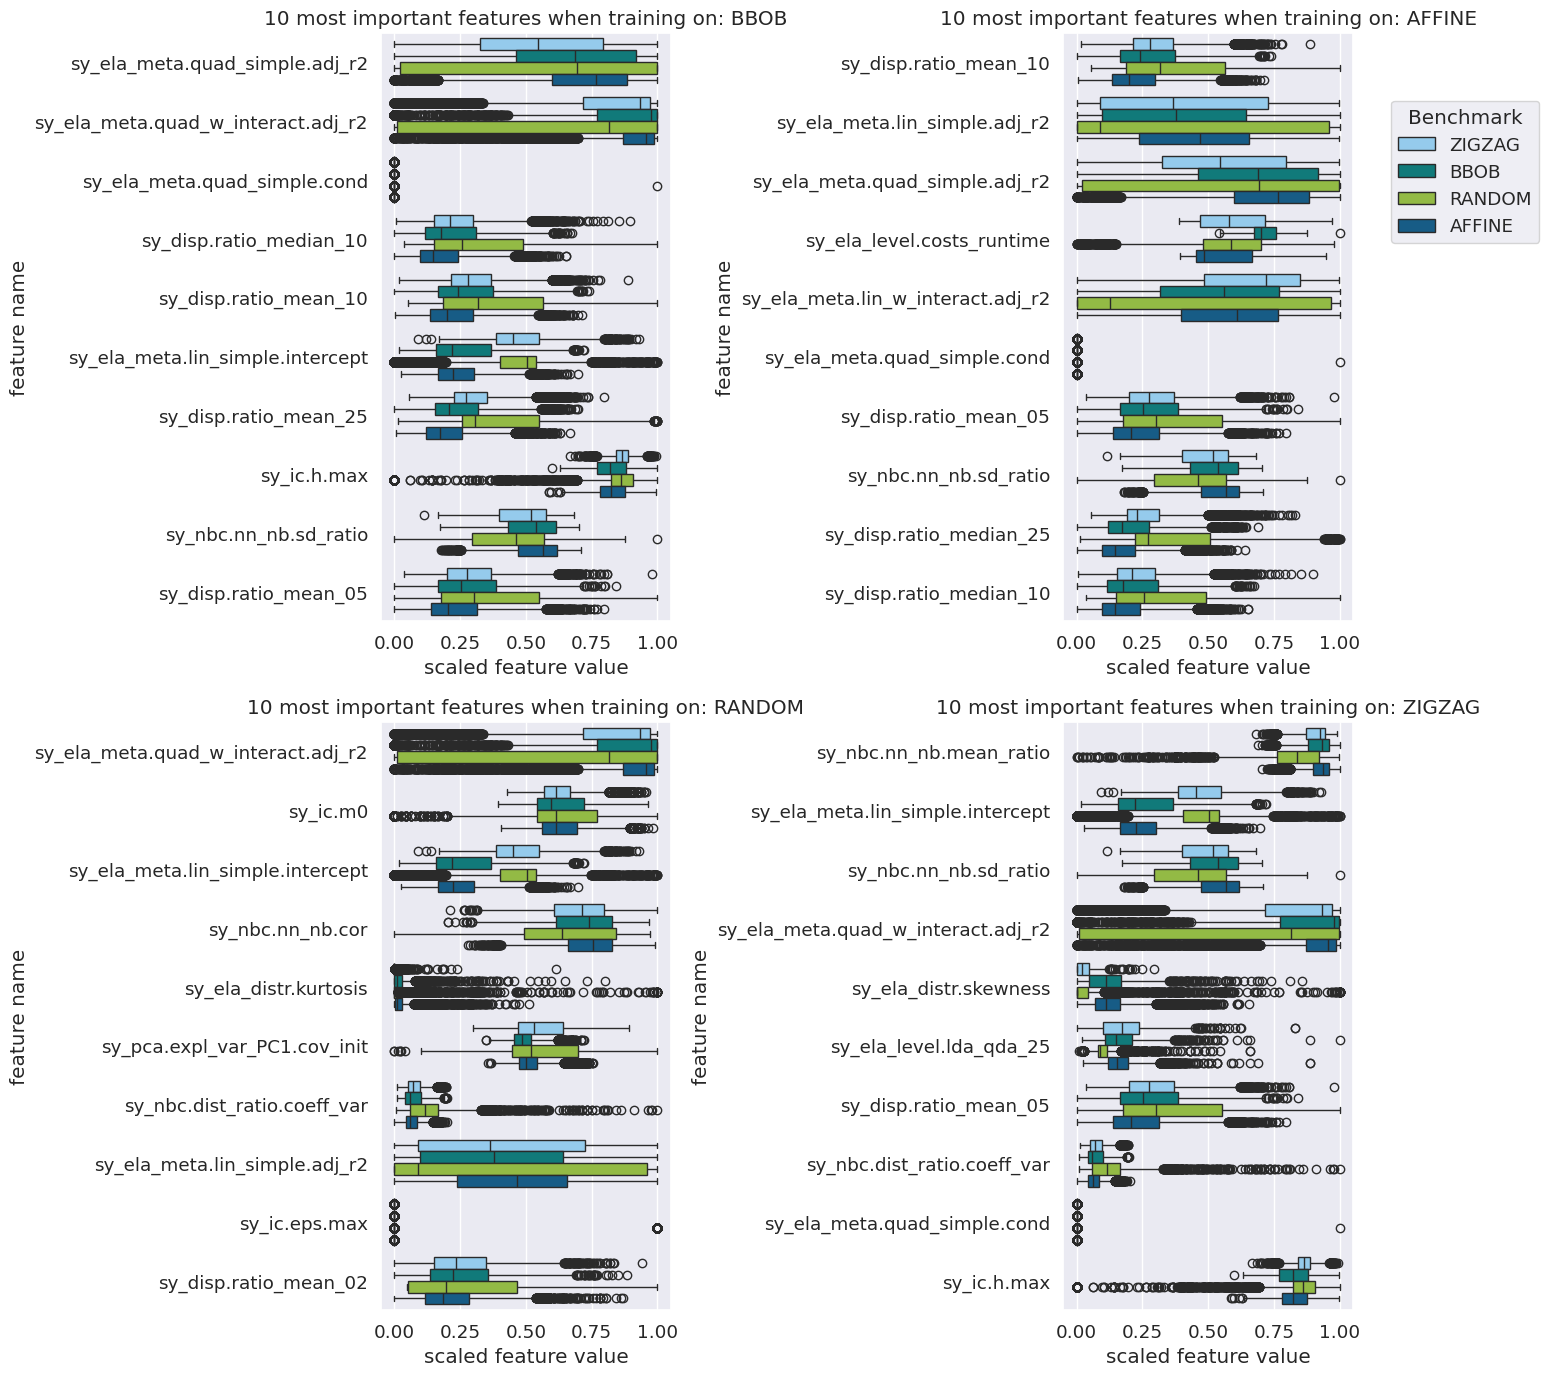

bbob
affine
random
m4


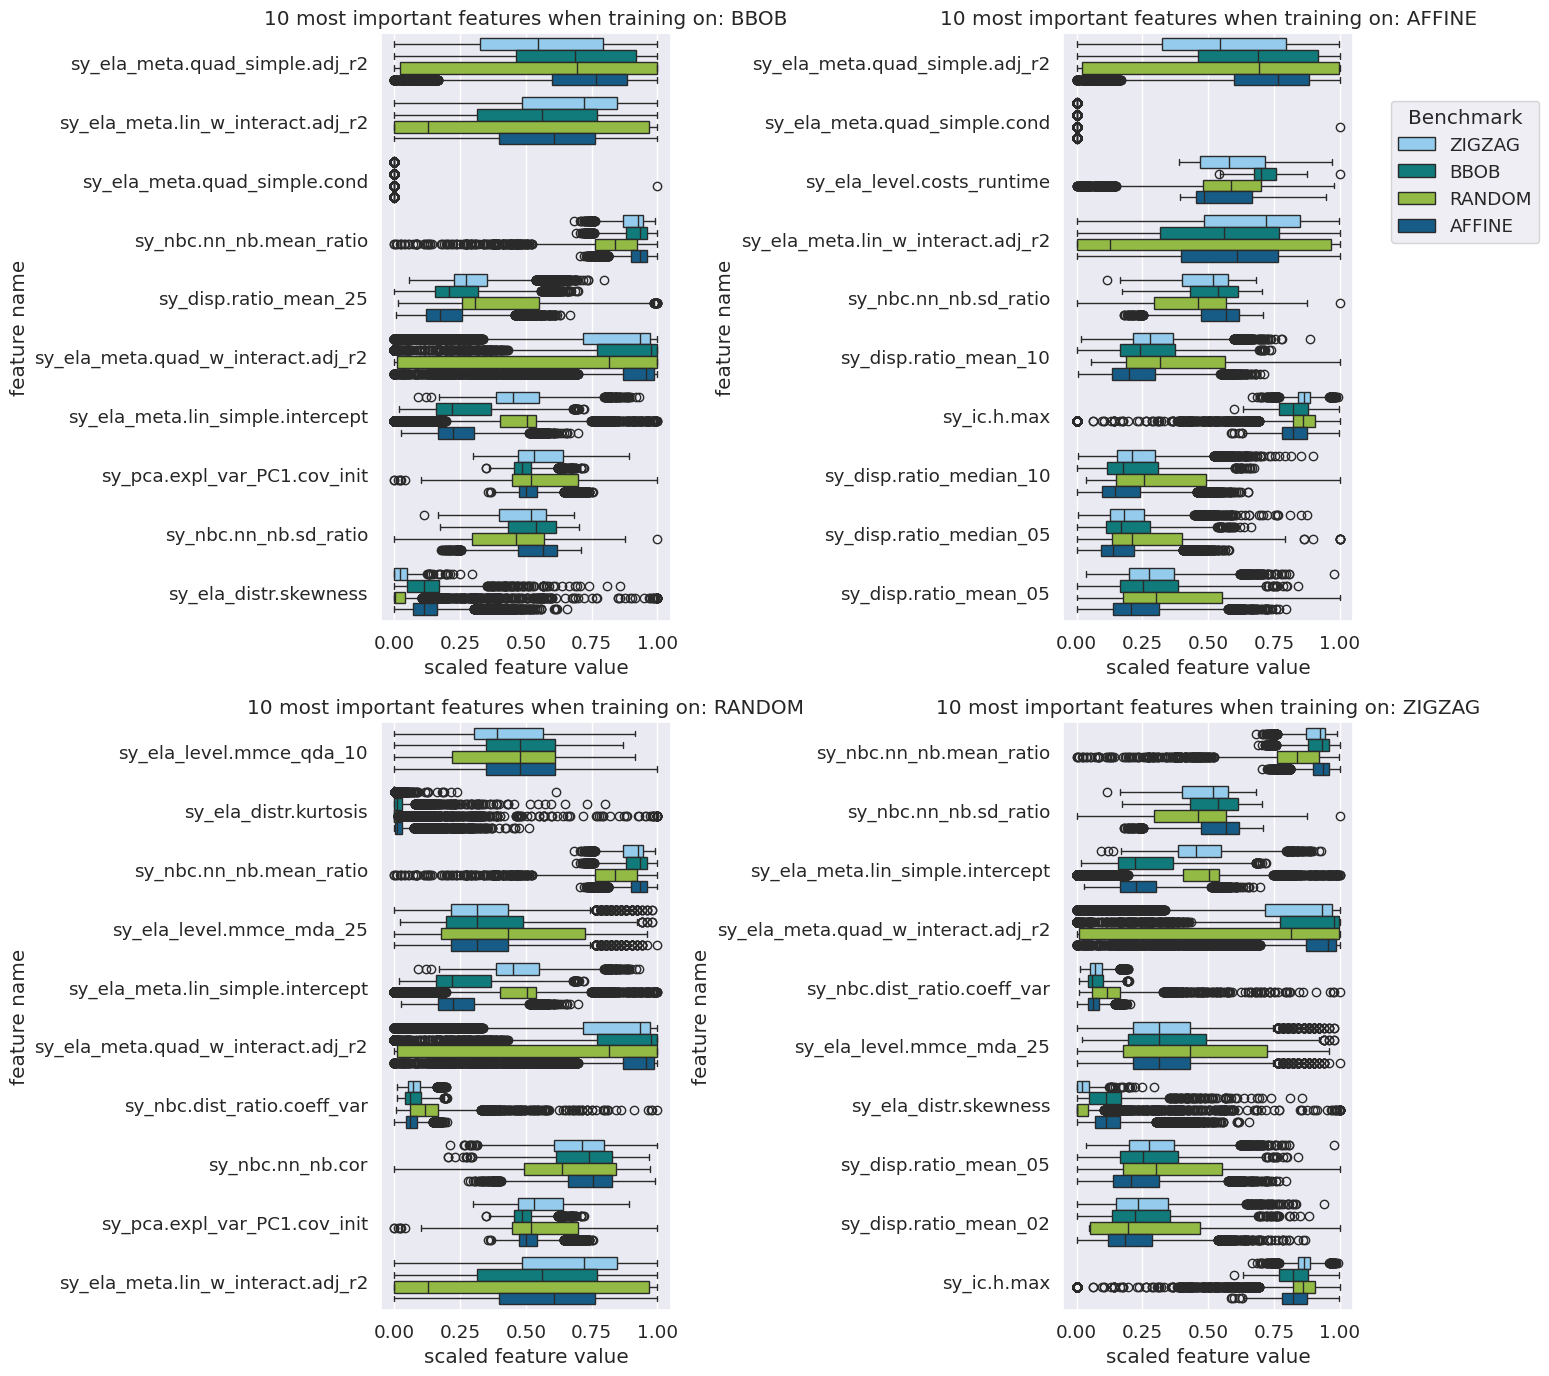

bbob
affine
random
m4


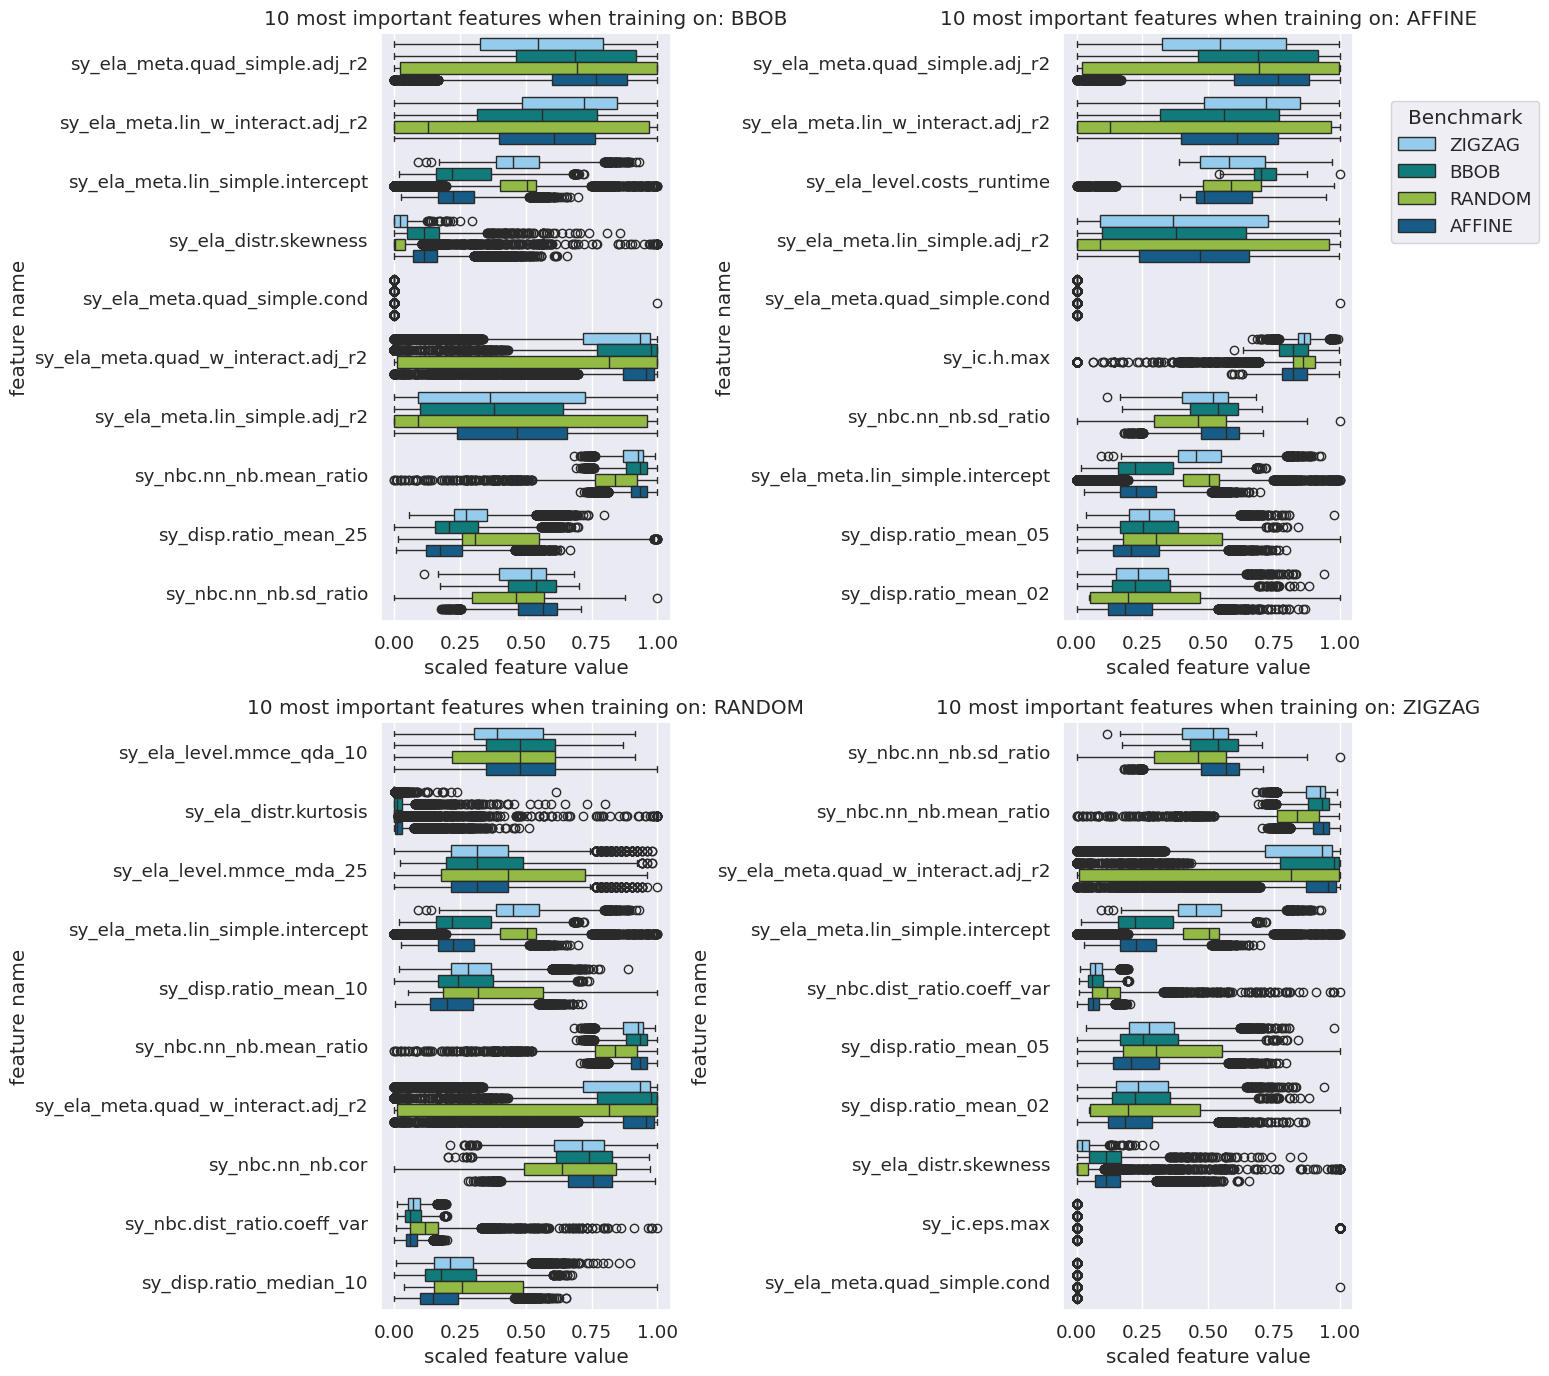

In [27]:
algorithms='DE-GA-ES-PSO'
sns.set(font_scale=1.2)
features='ELAsy'
sample_count_dimension_factor=50

feature_importance_all=pd.DataFrame()
for budget in [10,30,50]:
    fig,axes=plt.subplots(2,2, figsize=(16,14))
    feature_importance_all=pd.DataFrame()
    top_all=[]
    for train_index, train_benchmark in enumerate(all_benchmarks):
        print(train_benchmark)
        feature_importance=pd.concat([pd.read_csv(f'{data_dir}/results_ela/{sample_count_dimension_factor}d_samples/{dimension}d_generalization_discrete_ranking_False/{algorithms}/model_rf_budget_{budget}_fold_{fold}_train_{train_benchmark}_{features}_feature_importance.csv') for fold in range (0,10) ])
        feature_importance['train_benchmark']=benchmark_name_mapping(train_benchmark)
        feature_importance_all=pd.concat([feature_importance_all,feature_importance])
        top_features=[str(c) for c in feature_importance.groupby('feature').median(numeric_only=True).sort_values('importance', ascending=False).head(10).index]
        top_all+=top_features
        #most_important_features_per_benchmark[train_benchmark]=top_features
        ax=axes[int(train_index/2)][train_index%2]
        ax.set_title(f'10 most important features when training on: {benchmark_name_mapping(train_benchmark)}')
        feature_values_boxplot(all_features, f'{features}_{sample_count_dimension_factor}d', features_to_plot=top_features, ax=ax)
        if train_index!=1:
            ax.legend().set_visible(False)
        else:
            ax.legend(bbox_to_anchor=(1.1,0.9), title='Benchmark')

    plt.tight_layout()
    plt.savefig(f'{data_dir}/figures_results/feature_distribution_{algorithms}_dim_{dimension}_{features}_{sample_count_dimension_factor}d_samples_budget_{budget}.pdf')
    plt.show()
    
    '''plt.figure(figsize=(5,20))

    sns.boxplot(feature_importance_all.set_index('feature').loc[list(set(top_all))], x='importance',y='feature',hue='train_benchmark')
    plt.show()'''
                                         

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

def plot_clusters(all_features,features_to_plot):
    sns.set(font_scale=1)
    X = all_features[features_to_plot].drop(columns=['benchmark'])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = KMeans(n_init=10)
    visualizer = KElbowVisualizer(model, k=(1,20))
    visualizer.fit(X_scaled) # Fit the data to the visualizer
    visualizer.show() # Finalize and render the figure

    k = visualizer.elbow_value_

    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    y_pred = kmeans.fit_predict(X_scaled)
    sns.set(font_scale=1.5)
    x_copy=all_features[features_to_plot].copy()
    x_copy['cluster']=y_pred
    x_copy['c']=1
    x_copy['benchmark']=x_copy['benchmark'].apply(lambda x: benchmark_name_mapping(x))
    temp=x_copy.groupby(['benchmark','cluster']).count()['c'].reset_index().pivot('cluster', columns=['benchmark']).fillna(0)
    plt.figure()
    sns.heatmap(temp.droplevel(0, axis=1),annot=True, cmap='YlGnBu', fmt='.0f')
    plt.tight_layout()
    plt.savefig(f'{data_dir}/figures_problem/clustering_dimension_{dimension}_{features_to_plot}.pdf',bbox_inches='tight')

In [ ]:
plot_clusters(all_features,'ela_features_50d')

In [ ]:
plot_clusters(all_features,'ela_features_100d')

In [ ]:
plot_clusters(all_features,'transformer_features_50d')

In [ ]:
plot_clusters(all_features,'transformer_features_100d')

In [ ]:
plot_clusters(all_features,'merged_features_50d')

In [ ]:
plot_clusters(all_features,'merged_features_100d')